Importing libraries

In [11]:
import pandas as pd
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')
import re

# !pip install -q wordcloud
import wordcloud

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.core.display import Path
from gensim.scripts.glove2word2vec import glove2word2vec
import torch
import torch.nn as nn
from torchvision import datasets 
from torchvision.transforms import ToTensor
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import os

os.environ['PYTHONHASHSEED'] = str(69)
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve, auc
from sklearn.metrics import f1_score as skf1
from torchmetrics.functional import f1_score
from torchmetrics import ConfusionMatrix

'wget' is not recognized as an internal or external command,
operable program or batch file.


Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%unzip` not found.


In [2]:
def randreset(s):  #making sure each run will yield consistent results
	random.seed(s)
	np.random.seed(s)
	torch.manual_seed(s)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False
	torch.cuda.manual_seed_all(s)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Loading the data for preprocessing

In [4]:
path = 'imdb-reviews.csv'
jsonpath = 'save.json'

df = pd.read_csv(path,  sep='\t', lineterminator='\n')

Processing the data

In [5]:
df['review'] = df['review'].apply(lambda r: re.sub(r'\'', '', r))   #removing apostrophes so don't becomes dont
df['review'] = [r.lower() for r in df['review'] ]   #making everything lowercase
df['review'] = df['review'].apply(lambda r: re.sub(r'<br /><br />', ' ', r))  #removing this wierd sequence found in some reviews
df['review'] = df['review'].apply(lambda r: re.sub(r'[^a-z]', ' ', r))   #only keeping letters

rem = stopwords.words('english')
df['review'] = df['review'].apply(lambda r: ' '.join([word for word in r.split() if word not in rem]))


Vectorisation of the data

In [6]:
def vectorize(df, w2v):
	X = list()
	Y = list()
	# Scored are either positive or negative
	Scores = list(df['rating'].apply(lambda r: 1 if r > 5 else 0))

	for (i, review) in enumerate(df["review"].values):
		wvectors = list()
		for word in review.split(" "):
			if word in w2v.keys(): # Keeping only words in the vocabulary and using theur value
				wvectors.append(list(w2v[word]))
		if len(wvectors) > 0:
			X.append(np.mean(wvectors, axis=0)) #we keep the mean 
			Y.append(Scores[i])
	return (X,Y)


GloVe processing

In [8]:
w2v = {}

with open('glove.6B.300d.txt', encoding="utf8") as fp:
	for lines in fp:
		varray = lines.split(" ")
		w2v[varray[0]] = np.asarray(varray[1:], dtype='float32')

(X, Y) = vectorize(df, w2v)


FileNotFoundError: [Errno 2] No such file or directory: 'glove.6B.300d.txt'

Creating sets

In [9]:
randreset(666)
Xtrain, X1 , Ytrain, Y1 = train_test_split(X, Y, test_size=0.2, random_state=69)
Xval, Xtest , Yval, Ytest = train_test_split(X1, Y1, test_size=0.5, random_state=69)


Xt = torch.tensor(Xtrain, dtype=torch.float, device=device)
Yt = torch.tensor(Ytrain, device=device)
print(Xt.shape, Yt.shape)

Xv = torch.tensor(Xval, dtype=torch.float, device=device)
Yv = torch.tensor(Yval, device=device)
print(Xv.shape, Yv.shape)

XT = torch.tensor(Xtest, dtype=torch.float, device=device)
YT = torch.tensor(Ytest, device=device)
print(Xv.shape, Yv.shape)

TrainDataset = torch.utils.data.TensorDataset(Xt, Yt)
TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size=6001,shuffle=True)


torch.Size([36006, 300]) torch.Size([36006])
torch.Size([4501, 300]) torch.Size([4501])
torch.Size([4501, 300]) torch.Size([4501])


C:\Users\bgane\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  


Creating the model and functions

In [9]:
class NeuralNetwork(nn.Module):
  def __init__(self, Din, H1, H2, Dout, drop, activation) -> None:
      super(NeuralNetwork, self).__init__()
      self.linear_relu_stack = nn.Sequential(
          nn.Linear(Din, H1, device=device),
		      nn.Dropout(p=drop),
          activation(),
          nn.Linear(H1, H2, device=device),  
		      nn.Dropout(p=drop),
          activation(),
          nn.Linear(H2,Dout, device=device)
        )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

class NeuralNetwork2(nn.Module):
  def __init__(self, Din, H1, H2, H3,Dout, drop, activation) -> None:
    super(NeuralNetwork2, self).__init__()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(Din, H1, device=device),
        nn.Dropout(p=drop),
        activation(),
        nn.Linear(H1, H2, device=device),  
	      nn.Dropout(p=drop),
        activation(),
        nn.Linear(H2, H3, device=device), 
	      nn.Dropout(p=drop),
        activation(),
        nn.Linear(H3,Dout, device=device)
      )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits


In [10]:
def train(model, epochs, dataloader, optimiser, learningrate, Xval, Yval, prinntTF):
	lastf1 = None
	lastmodel = None
	lossfunction = nn.CrossEntropyLoss()
	optim = getattr(torch.optim, optimiser)(model.parameters(), lr=learningrate) 
	for ep in range(epochs):
		model.train()
		for batch, (X,Y) in enumerate(dataloader):
			X = X.to(device)
			Y = Y.to(device)
			Ypred = model(X)
			l = lossfunction(Ypred, Y)
			l.backward()
			optim.step()
			optim.zero_grad()
		with torch.no_grad(): #early stopping if the validation set, gets worse results
			model.eval()
			_, Vpred = torch.max(model(Xval), 1)
			f1 = f1_score(Yval.cpu(), Vpred.cpu(), average="weighted", num_classes=2)
			if prinntTF:
				print(f"for epoch = {ep} we got loss = {l.item()} and f1 score with val set = {f1}")
			if lastf1 is None:
				lastf1 = f1 
				lastmodel = model
			else:
				if lastf1 > f1:
					return lastmodel
				else:
					lastf1 = f1
					lastmodel = model

			
	return model


def testf(model, Xtest, Ytest, f):
	with torch.no_grad():
		model.eval()
		_, Ypred = torch.max(model(Xtest), 1)
		Ypred = Ypred.cpu()
		Ytest = Ytest.cpu()
		f.write(classification_report(Ytest, Ypred))

def test(model, Xtest, Ytest):
	with torch.no_grad():
		model.eval()
		_, Ypred = torch.max(model(Xtest), 1)
		Ypred = Ypred.cpu()
		Ytest = Ytest.cpu()
		print(classification_report(Ytest, Ypred))



Model Parameter Tuning
(skip running this portion since it takes many hours to complete)

In [12]:
randreset(666) #starting with some random parameters to test the model works
model = NeuralNetwork(Xt.shape[1], 512, 512, 2, 0.3, nn.ReLU).to(device)
model = train(model, 100, TrainDataloader, "Adam", 0.02, Xv, Yv, True)
test(model, XT, YT)

for epoch = 0 we got loss = 1.6506773233413696 and f1 score with val set = 0.3598181903362274
for epoch = 1 we got loss = 0.6665911078453064 and f1 score with val set = 0.7170917391777039
for epoch = 2 we got loss = 0.5773402452468872 and f1 score with val set = 0.7437430620193481
for epoch = 3 we got loss = 0.5106748938560486 and f1 score with val set = 0.7987346649169922
for epoch = 4 we got loss = 0.4814921021461487 and f1 score with val set = 0.812169075012207
for epoch = 5 we got loss = 0.4379153847694397 and f1 score with val set = 0.8126370906829834
for epoch = 6 we got loss = 0.42453381419181824 and f1 score with val set = 0.824476957321167
for epoch = 7 we got loss = 0.3934515118598938 and f1 score with val set = 0.8216426968574524
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      2273
           1       0.78      0.88      0.82      2228

    accuracy                           0.82      4501
   macro avg       0.82      0.

In [ ]:
f = open("out.txt", "w") #trying diffrent neuron sizes, activation functions, dropout rates, optimisers and learning rates
for neur in [128, 512, 1024, 2048]:
	for activ in [nn.ReLU, nn.CELU, nn.Hardshrink, nn.GELU, nn.SiLU]:
		for drop in [0.1,0.2,0.3,0.4,0.5,0.6]:
			for optim in ["SGD", "Adam", "Adagrad", "Adamax", "RMSprop"]:
				for lr in [0.02,0.04,0.06,0.08, 0.1, 0.2, 0.3]:
					randreset(666)
					model = NeuralNetwork(Xt.shape[1], neur, neur, 2,drop, activ).to(device)
					model = train(model, 100, TrainDataloader, optim, lr, Xv, Yv, False)
					f.write(f"for neur = {neur}, activation = {activ}, dropout = {drop}, optimiser = {optim}, lr = {lr}")
					testf(model, XT, YT, f)
f.close()

In [2]:
f = open("out.txt", "r") #interpreting the results and finding the best combinations
bestacc = -1
bestline = list()
for i in range(4200):	
	line1 = f.readline()
	line2 = f.readline()
	line3 = f.readline()
	line4 = f.readline()
	line5 = f.readline()
	line6 = f.readline()
	line7 = f.readline()
	line8 = f.readline()

	acc = line6.split()
	if float(acc[1]) > bestacc:
		bestacc = float(acc[1])
		bestline = [line1]
	elif float(acc[1]) == bestacc:
		bestline.append(line1)
print(bestacc)
for l in bestline:
	print(l)

f.close()

0.83
for neur = 128, activation = <class 'torch.nn.modules.activation.ReLU'>, dropout = 0.1, optimiser = Adam, lr = 0.04              precision    recall  f1-score   support

for neur = 128, activation = <class 'torch.nn.modules.activation.ReLU'>, dropout = 0.1, optimiser = Adam, lr = 0.06              precision    recall  f1-score   support

for neur = 128, activation = <class 'torch.nn.modules.activation.ReLU'>, dropout = 0.1, optimiser = Adam, lr = 0.08              precision    recall  f1-score   support

for neur = 128, activation = <class 'torch.nn.modules.activation.ReLU'>, dropout = 0.1, optimiser = Adamax, lr = 0.02              precision    recall  f1-score   support

for neur = 128, activation = <class 'torch.nn.modules.activation.ReLU'>, dropout = 0.1, optimiser = Adamax, lr = 0.08              precision    recall  f1-score   support

for neur = 128, activation = <class 'torch.nn.modules.activation.ReLU'>, dropout = 0.2, optimiser = Adam, lr = 0.02              precision   

In [83]:
randreset(666) #trying one of the best results
model = NeuralNetwork(Xt.shape[1], 128, 128, 2, 0.2, nn.CELU).to(device)
model = train(model, 100, TrainDataloader, "Adam", 0.02, Xv, Yv, True)
test(model, XT, YT)

for epoch = 0 we got loss = 0.6712283492088318 and f1 score with val set = 0.6722713708877563
for epoch = 1 we got loss = 0.6338800191879272 and f1 score with val set = 0.7523807883262634
for epoch = 2 we got loss = 0.516694188117981 and f1 score with val set = 0.7771332263946533
for epoch = 3 we got loss = 0.4458700716495514 and f1 score with val set = 0.7947189807891846
for epoch = 4 we got loss = 0.43640902638435364 and f1 score with val set = 0.8070963025093079
for epoch = 5 we got loss = 0.40242454409599304 and f1 score with val set = 0.816131591796875
for epoch = 6 we got loss = 0.3977370858192444 and f1 score with val set = 0.8219792246818542
for epoch = 7 we got loss = 0.37404435873031616 and f1 score with val set = 0.825736403465271
for epoch = 8 we got loss = 0.3887227773666382 and f1 score with val set = 0.8283443450927734
for epoch = 9 we got loss = 0.38116833567619324 and f1 score with val set = 0.8313820362091064
for epoch = 10 we got loss = 0.3597605526447296 and f1 scor

In [ ]:
f = open("out2.txt", "w")	#trying with the previus hyper parameters, varius 2 hidden layer neuron combinations
for H1 in [128, 512, 1024, 2048]:
	for H2 in [128, 512, 1024, 2048]:
		for H3 in [128, 512, 1024, 2048]:
			randreset(69)
			model = NeuralNetwork2(Xt.shape[1], H1, H2, H3, 2, 0.4, nn.CELU).to(device)
			model = train(model, 100, TrainDataloader, "Adam", 0.02, Xv, Yv, False)
			f.write(f"For H1 = {H1} , H2 = {H2}, H3 = {H3}")
			testf(model, XT, YT, f)
f.close()

In [28]:
f = open("out2.txt", "r")
bestacc = -1
bestline = list()
for i in range(64):	
	line1 = f.readline()
	line2 = f.readline()
	line3 = f.readline()
	line4 = f.readline()
	line5 = f.readline()
	line6 = f.readline()
	line7 = f.readline()
	line8 = f.readline()

	acc = line6.split()
	if float(acc[1]) > bestacc:
		bestacc = float(acc[1])
		bestline = [line1]
	elif float(acc[1]) == bestacc:
		bestline.append(line1)
print(bestacc)
for l in bestline:
	print(l)

f.close() #We see from the results, not much success with 2 hidden layers

0.81
For H1 = 512 , H2 = 128, H3 = 128              precision    recall  f1-score   support



Testing learning rate scheduler

In [81]:

def trainsched(model, epochs, dataloader, optimiser, learningrate, Xval, Yval, prinntTF, scheduler):
	lastf1 = None
	lastmodel = None
	lossfunction = nn.CrossEntropyLoss()
	optim = getattr(torch.optim, optimiser)(model.parameters(), lr=learningrate) 
	sched = getattr(torch.optim.lr_scheduler, scheduler)(optim, step_size=10)
	# sched = getattr(torch.optim.lr_scheduler, scheduler)(optim, gamma=0.1)
	for ep in range(epochs):
		model.train()
		for batch, (X,Y) in enumerate(dataloader):
			X = X.to(device)
			Y = Y.to(device)
			Ypred = model(X)
			l = lossfunction(Ypred, Y)
			l.backward()
			optim.step()
			optim.zero_grad()
		with torch.no_grad():
			model.eval()
			_, Vpred = torch.max(model(Xval), 1)
			f1 = f1_score(Yval.cpu(), Vpred.cpu(), average="weighted", num_classes=2)
			if prinntTF:
				print(f"for epoch = {ep} we got loss = {l.item()} and f1 score with val set = {f1}")
			if lastf1 is None:
				lastf1 = f1 
				lastmodel = model
			else:
				if lastf1 > f1:
					return lastmodel
				else:
					lastf1 = f1
		sched.step()
			
	return model


In [82]:
#We tied some learning rate schedulers but they didn't imrove our score
randreset(666)
model = NeuralNetwork(Xt.shape[1], 128, 128, 2, 0.2, nn.CELU).to(device)
model = trainsched(model, 100, TrainDataloader, "Adam", 0.02, Xv, Yv, False, "StepLR")
# model = trainsched(model, 100, TrainDataloader, "Adam", 0.02, Xv, Yv, False, "ExponentialLR")
test(model, XT, YT)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      2273
           1       0.81      0.83      0.82      2228

    accuracy                           0.82      4501
   macro avg       0.82      0.82      0.82      4501
weighted avg       0.82      0.82      0.82      4501



FINAL RESULTS, ROC CURVE and LEARNING CURVE

In [11]:
randreset(666)
model = NeuralNetwork(Xt.shape[1], 128, 128, 2, 0.2, nn.CELU).to(device)
model = train(model, 100, TrainDataloader, "Adam", 0.02, Xv, Yv, False)
test(model, XT, YT)

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      2273
           1       0.84      0.80      0.82      2228

    accuracy                           0.83      4501
   macro avg       0.83      0.83      0.83      4501
weighted avg       0.83      0.83      0.83      4501



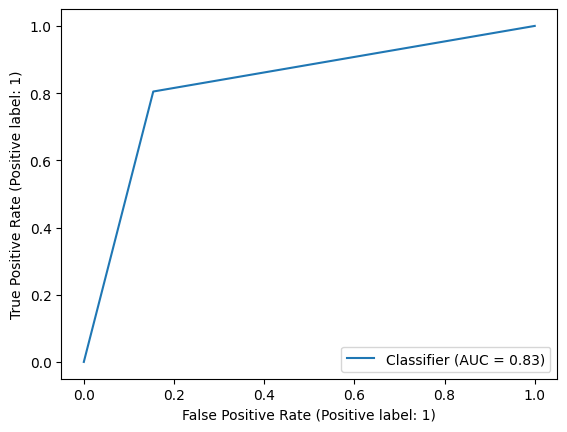

In [12]:
def plotROC(model, Xtest, Ytest):
	with torch.no_grad():
		model.eval()
		_, Ypred = torch.max(model(Xtest), 1)
		Ypred = Ypred.cpu()
		Ytest = Ytest.cpu()
		RocCurveDisplay.from_predictions(Ytest, Ypred)
		plt.show()
plotROC(model, XT, YT)


Learning Curve

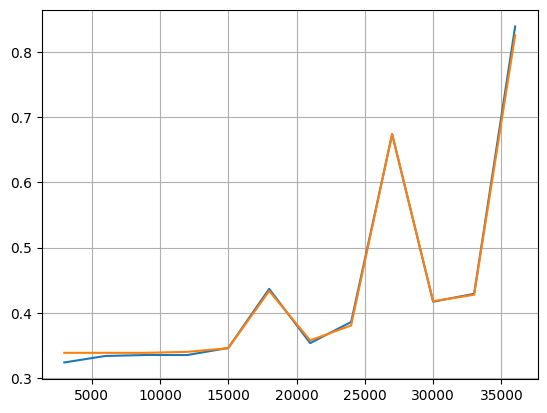

In [13]:
randreset(666)
Xtrain, X1 , Ytrain, Y1 = train_test_split(X, Y, test_size=0.2, random_state=69)
Xval, Xtest , Yval, Ytest = train_test_split(X1, Y1, test_size=0.5, random_state=69)

Xt = torch.tensor(Xtrain, dtype=torch.float, device=device)
Yt = torch.tensor(Ytrain, device=device)

Xv = torch.tensor(Xval, dtype=torch.float, device=device)
Yv = torch.tensor(Yval, device=device)

XT = torch.tensor(Xtest, dtype=torch.float, device=device)
YT = torch.tensor(Ytest, device=device)

Tscores = []
Vscores = []
for size in [3000,6000,9000,12000,15000,18000,21000,24000,27000,30000,33000,36006]:
	TrainDataset = torch.utils.data.TensorDataset(Xt[:size], Yt[:size])
	TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size=6001,shuffle=True)
	randreset(666)
	model = NeuralNetwork(Xt.shape[1], 128, 128, 2, 0.2, nn.CELU).to(device)
	model = train(model, 100, TrainDataloader, "Adam", 0.02, Xv, Yv, False)
	_, Ptrain = torch.max(model(Xt[:size]), 1)
	Ptrain = Ptrain.cpu()
	Ptraintrue = Yt.cpu()
	_, Ptest = torch.max(model(XT), 1)
	Ptest = Ptest.cpu()
	Ptesttrue = YT.cpu()
	Tscores+= [skf1(Ptraintrue[:size], Ptrain, average="weighted")]
	Vscores += [skf1(Ptesttrue, Ptest, average="weighted")]
	
plt.grid()
plt.plot([3000,6000,9000,12000,15000,18000,21000,24000,27000,30000,33000,36006], Tscores, label="Train Score")
plt.plot([3000,6000,9000,12000,15000,18000,21000,24000,27000,30000,33000,36006], Vscores, label="Test Score")
plt.show()